## Opis projektu
Celem projektu było przygotowanie modelów rozpoznających 6 typów szkła na podstawie ich zawartości następujących pierwiastków:  Na, Mg, Al, Si, K, Ca, Ba, Fe oraz współczynnika RI. (link do danych:http://archive.ics.uci.edu/ml/datasets/glass+identification). Następnie porównano różne modele, ich skuteczności oraz wizualizacje je. W dalszych rozważaniach skorzystano również z bibliotek PyTorch oraz użyto bibliotekę Captum służącą interpretacji (stosunkowo nową na rynku).


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from collections import deque
import pandas as pd
import matplotlib as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.svm import SVC
import torch
import torch.nn as nn
from captum.attr import IntegratedGradients, NoiseTunnel, GradientShap, LayerConductance


In [2]:

cols = ['Id','RI','Na','Mg','Al',
        'Si','K','Ca','Ba','Fe','Type of glass']

data = pd.read_csv(r"D:\Projekty\untitled\data\glass.data", sep=',+',
                   engine='python', header=None, 
                   names=cols)


Tak prezentują się wyeksportowane dane:

In [50]:
data.head()

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Poniżej przedstawiono heatmape informującą o tym jak silnie skorelowane są ze sobą poszczególne cechy. 

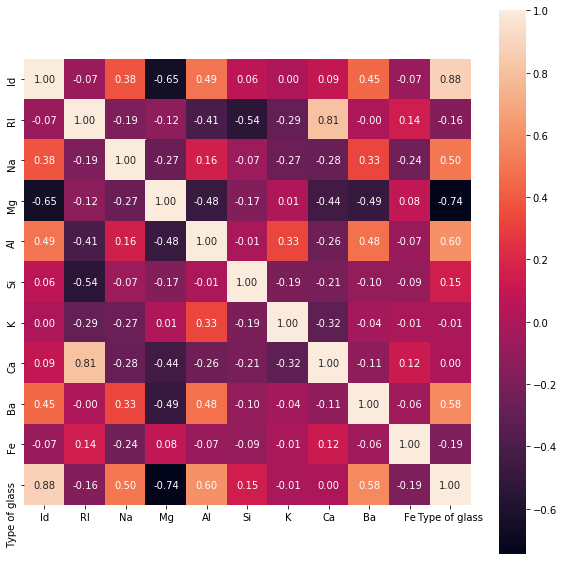

In [20]:
corr_matrix = np.corrcoef(data.values.T)
fig, ax = plp.subplots(figsize=(10,10))
sns.heatmap(data=corr_matrix,
            annot=True,
            square = True,
            fmt='.2f',
            xticklabels=cols,
            yticklabels=cols)


Na poniższych wykresach pudełkowych widać liczne występowania outlinerów w poszczególnych cechach, które należy usunąć. 

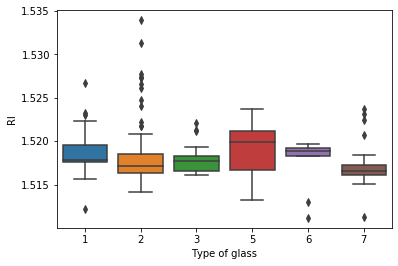

In [5]:
sns.boxplot(x=data['Type of glass'], y=data['RI'])

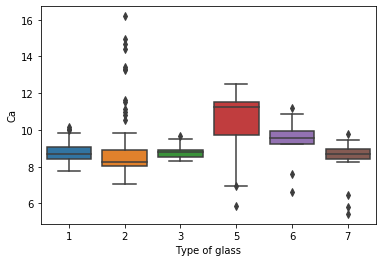

In [9]:
sns.boxplot(x=data['Type of glass'], y=data['Ca'])

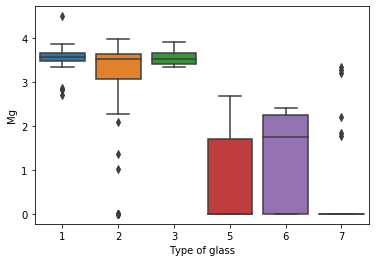

In [8]:
sns.boxplot(x=data['Type of glass'], y=data['Mg'])

Do zmiennej Q1 zapisano wartość kwantyla 0.25, a do zmiennej Q3 wartość dla kwantyla 0.75. Następnie obliczono IQR jako różnicę Q3 i Q1. Usunięto próbki o zbyt dużym rozstępie. 

In [3]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

outlier_condition = ((data <(Q1-1.5*IQR)) | (data > (Q3+1.5*IQR)))
data_iqr = data[~outlier_condition.any(axis=1)]     #zbiór danych pomniejszony o zbyt odstające próbki

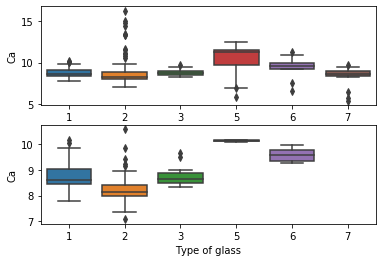

In [19]:
#Ca przed i po usunięciem outlinerów
plp.subplot(211)
sns.boxplot(x=data['Type of glass'], y=data['Ca'])
plp.subplot(212)
sns.boxplot(x=data['Type of glass'], y=data_iqr['Ca'])

## Normalizacja
Z powodu małej ilości danych oraz ich dużego rozproszenia w obrębie typu szkła 7, podjęto decyzję o pominięciu tej etykiety.Kolejnym krokiem jest skalowanie danych. 

In [4]:
X = data_iqr[['RI','Na','Mg','Al',
        'Si','K','Ca','Ba','Fe']]
y = data_iqr['Type of glass'].values


scaler = StandardScaler()
scaler.fit(X)
X_std =scaler.transform(X)


Po przeskalowaniu zmniejszyła się ilość próbek występujących w danej cesze.

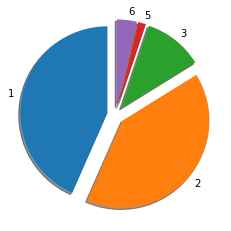

In [57]:
tab=np.ones(6)
tab[0]=np.count_nonzero(y == 1) 
tab[1]=np.count_nonzero(y == 2) 
tab[2]=np.count_nonzero(y == 3) 
tab[3]=np.count_nonzero(y == 5) 
tab[4]=np.count_nonzero(y == 6)  
  

labels = '1', '2', '3', '5', '6'
sizes = [tab[0], tab[1], tab[2], tab[3],tab[4]]
explode = (0.1, 0.1, 0.1, 0.1,0.1)  

fig1, ax1 = plp.subplots()
ax1.pie(sizes, explode=explode, labels=labels, shadow=True, startangle=90)

plp.show()


## Nearest Neighbors
Na początek wybrano klasyfikator Nearest Neighbors. Użyto parametru 'distance', który sprawia że, bliżsi sąsiedzi będą mieli większy wpływ niż ci bardziej oddaleni. Ilość sąsiadów przyjęto na 15.

In [61]:
# Usunięto outlinerów, przeskalowano,
X_train,X_test,y_train,y_test = train_test_split(X_std,y,test_size=0.2)


clf = neighbors.KNeighborsClassifier(15, weights='distance')
clf.fit(X_train, y_train)

y_pred =clf.predict(X_test)

my_score=np.where(y_pred == y_test, 1, 0)

wynik = np.count_nonzero(my_score)/len(my_score)*100
print("Wynik procentowy  %i procent"% wynik)


Wynik procentowy  75 procent


In [62]:
# NIE usinieto outlinerow, NIE przeskalowano 
 

X_2 = data[['RI','Na','Mg','Al',
        'Si','K','Ca','Ba','Fe']]
y_2 = data['Type of glass'].values

abc = neighbors.KNeighborsClassifier(15, weights='distance')

X_train,X_test,y_train,y_test = train_test_split(X_2,y_2,test_size=0.2)

abc.fit(X_train, y_train)

y_pred =abc.predict(X_test)

my_score=np.where(y_pred == y_test, 1, 0)

wynik = np.count_nonzero(my_score)/len(my_score)*100
print("Wynik procentowy  %i procent"% wynik)


Wynik procentowy  58 procent


Model dla uprzednio przygotowanych danych myli się rzadziej o kilka punktów procentowych niż dla "surowych" danych. 

## Wizualizacja kalsyfiakcji 
Poniżej przedstawiono na wykresie punkty niektórych par cech ze zbioru danych oraz ich kwalifikacje do poszczególnych etykiet. Predykcje ustanowiono na zbiorze treningowym. Po przygotowaniu danych występuje 5 etykiet: 1,2,3,5,6. Kolorów kropek jest pięć, nie występują żadne różowe kropki. Dlaczego tak jest? Zbiór danych po przygotowaniu posiada jedynie 2 próbki szkła typu 5.  Model zakwalifikował te dwie próbki szkła typu 5 do najbliższych im etykiet. Przy tak małej liczbie danych całego zbioru i niesymetrycznych ilościach danych poszczególnych cech ciężko  jest stworzyć dobry model predykcyjny.

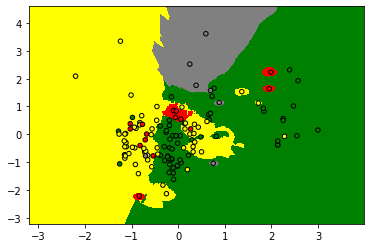

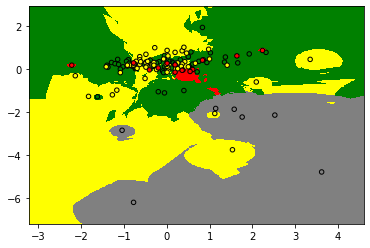

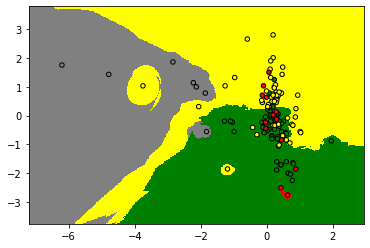

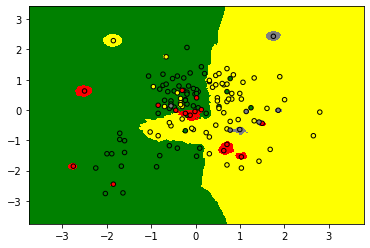

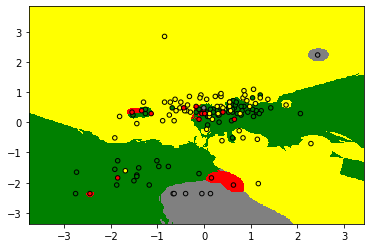

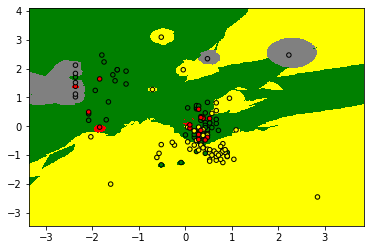

In [66]:
n_neighbors = 15

for i in range(6):
    X = X_std[:, i:i+2]
    h = .02 
    cmap_light = ListedColormap(['green', 'yellow', 'red','pink','grey'])
    cmap_bold = ListedColormap(['green', 'yellow', 'red','pink','grey'])
    
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf.fit(X, y)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    
    Z = Z.reshape(xx.shape)
    

    
    plp.figure()
    plp.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plp.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plp.xlim(xx.min(), xx.max())
    plp.ylim(yy.min(), yy.max())
    plp.show()
    



## SVC
Kolejny model wypadł lepiej. Jest on wstanie przewidywać etykiety dla danych testowych z około 75-80% skutecznością. Ten algorytm ma za zadanie zwrócić najlepiej dopasowaną płaszczyznę, która dzieli oraz kategoryzuje dane.

In [88]:

X_train,X_test,y_train,y_test = train_test_split(X_std,y,test_size=0.2)


clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

y_pred =clf.predict(X_test)

my_score=np.where(y_pred == y_test, 1, 0)

wynik = np.count_nonzero(my_score)/len(my_score)*100
print("Wynik procentowy  %i procent"% wynik)

Wynik procentowy  82 procent


## DecisionTreeClassifier
W tym algorytmie w tych strukturach drzew liście reprezentują etykiety klas, a gałęzie reprezentują połączenia cech, które prowadzą do tych właśnie etykiet. Jest on o tyle ciekawy, iż pozwala na śledzenie podejmowanych decyzji na podstawie wyrysowanego drzewa.

In [45]:
X_train,X_test,y_train,y_test = train_test_split(X_std,y,test_size=0.2)


cla = DecisionTreeClassifier()
cla.fit(X_train, y_train)

y_pred =cla.predict(X_test)

my_score=np.where(y_pred == y_test, 1, 0)

wynik = np.count_nonzero(my_score)/len(my_score)*100
print("Wynik procentowy  %i procent"% wynik)

Wynik procentowy  85 procent


## Drzewo decyzyjne

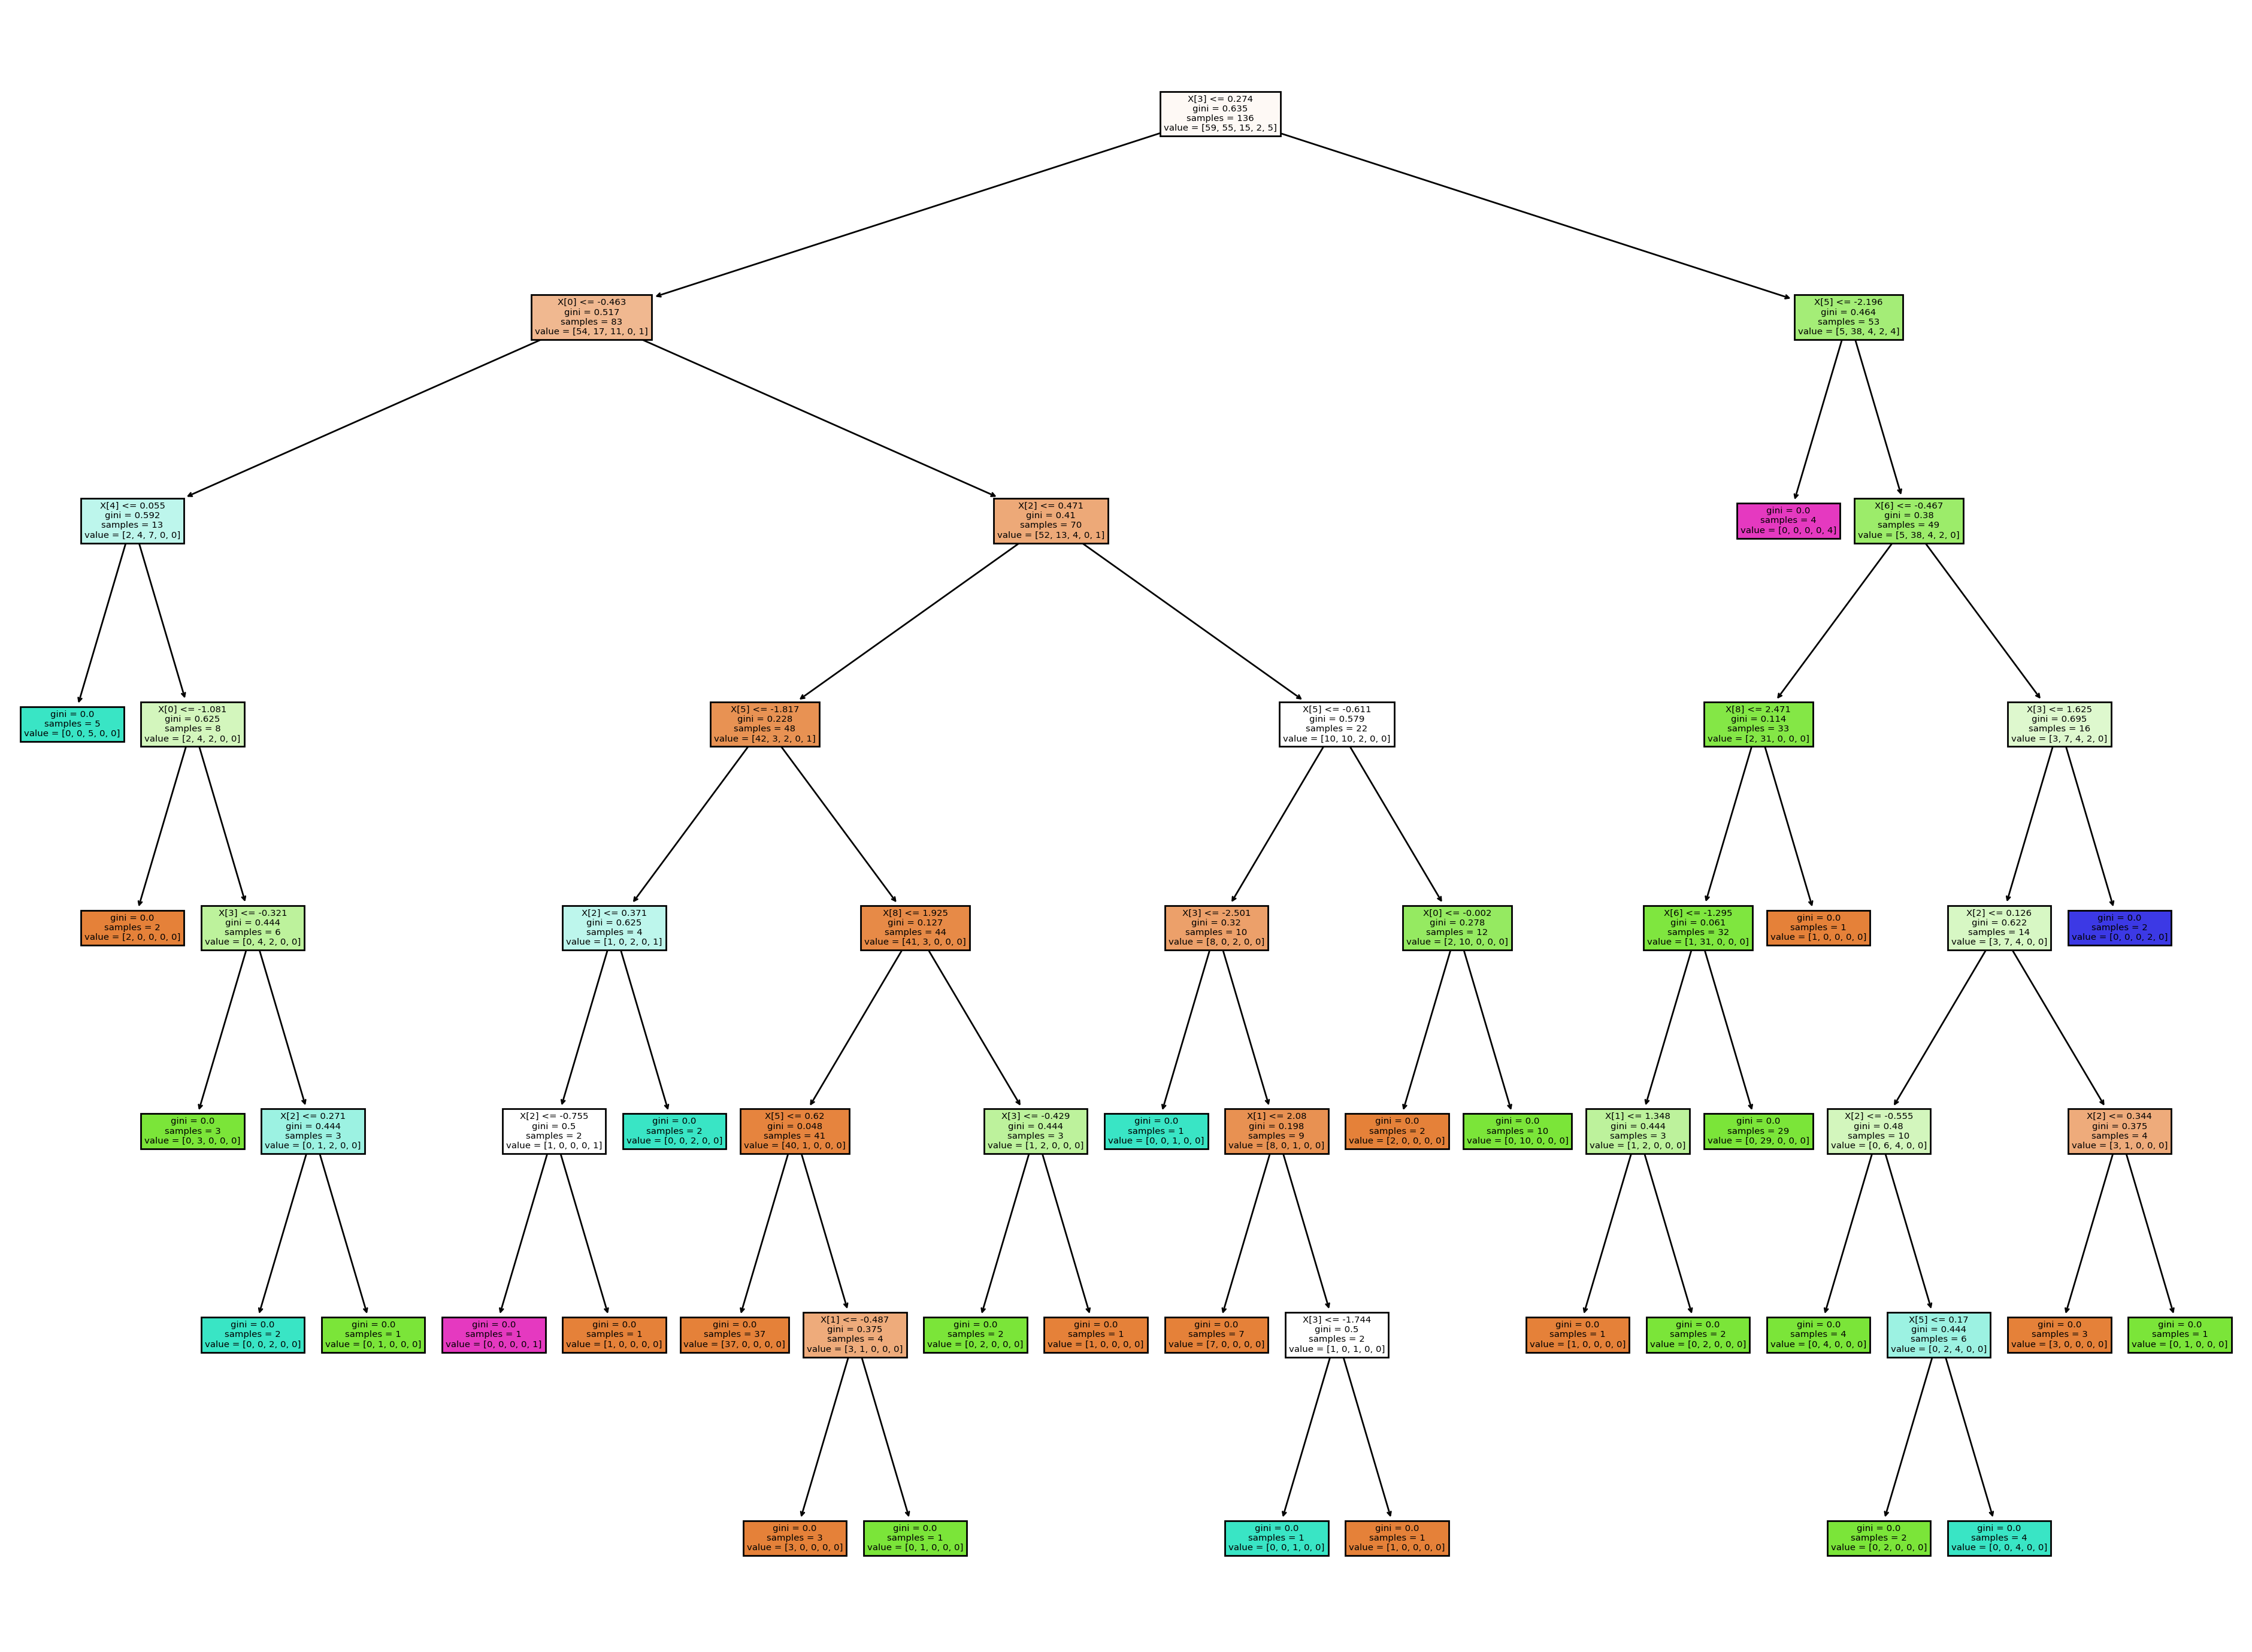

In [46]:
plp.figure(num=None, figsize=(24, 18), dpi=200, facecolor='w', edgecolor='b')
clf = DecisionTreeClassifier().fit(X_std, y)
plot_tree(clf, filled=True)
plp.show()

## Wizualizacja klasyfikacji
Poniżej zaprezentowano klasyfikacje typów szkła na podstawie par cech np. (Na,RI), (Mg, Na), (Al, Mg) itd. Typy szkła 1,2,3,5,6 mają odpowiednio kolory zielony, żółty, czerwony, niebieski, czarny. Na wykresach brakuje kropek w kolorze czarnym (właśnie przez błędną kwalifikacje). W odróżnieniu od SVC, tutaj próbki będące typem szkła 6 zostały oznaczone jako 5.

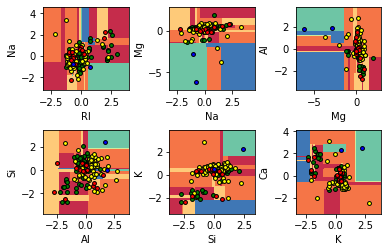

In [47]:
labels_x=[1,2,3,5,6]
n_classes = 4
plot_colors = ['green', 'yellow', 'red','blue','black']
plot_step = 0.02
a=1

glass_label =[1,2,3,5,6]
for pairidx, pair in enumerate([[0, 1], [1, 2], [2, 3],
                                [3, 4], [4, 5], [5, 6]]):
    
    X = X_std[:, pair]
   
    abc = DecisionTreeClassifier().fit(X, y)

  
    plp.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plp.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = abc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plp.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    
    plp.xlabel(data.columns[a])
    plp.ylabel(data.columns[a+1])
    a+=1

    
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == labels_x[i])
        plp.scatter(X[idx, 0], X[idx, 1], c=color, label=glass_label[i], edgecolor='black', s=15)

## Implementacja w Pytorchu
Jednym z częstych sposobów rozwiązywania problemów z machine learning jest biblioteka Pytorch. Jest ona jedną z dwóch najczęściej używanych bibliotek do Deeplearningu. W związku z tym prosta sieć stworzona w tej bibliotece zostanie zastosowana do rozwiązania problemów rodzajów szkła, a następnie przy użyciu biblioteki Captum sieć zostanie w podstawowy sposób zinterpretowana.

Poniżej zaprezentowana jest sieć użyta do przewidzenia rodzaju szkła z podanych cech:

In [5]:
train_features, test_features, train_labels, test_labels = train_test_split(X_std,y,test_size=0.2)

class GlassSimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(9, 100)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(100, 50)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(50, 25)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(25, 8)

    def forward(self, x):
        return self.linear4(self.relu3(self.linear3(self.relu2(self.linear2(self.relu1(self.linear1(x)))))))

Jako funkcja kosztu użyta została funkcja CrossEntropyLoss z argumentami domyślnymi, a do optymalizacji został użyty algorytm Adam bazujący na stochastycznej optymalizacji gradientu.

In [9]:
net = GlassSimpleModel()        

criterion = nn.CrossEntropyLoss()
num_epochs = 100

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)
for epoch in range(num_epochs):    
    output = net(input_tensor)
    loss = criterion(output, label_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print ('Epoka  {}/{} => Koszt: {:.2f}'.format(epoch+1, num_epochs, loss.item()))


out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Wynik na danych uczących:", sum(out_classes == train_labels) / len(train_labels))

test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Wynik na danych testujących:", np.round(sum(out_classes == test_labels) / len(test_labels),3))

Epoka  1/100 => Koszt: 2.06
Epoka  21/100 => Koszt: 0.47
Epoka  41/100 => Koszt: 0.08
Epoka  61/100 => Koszt: 0.02
Epoka  81/100 => Koszt: 0.00
Wynik na danych uczących: 1.0
Wynik na danych testujących: 0.571


Jak widać algorytm sprawuje się całkiem dobrze, a na pewno znacząco lepiej niż wynosi prawdopodobieństwo wyboru losowego, które w tym przypadku wynosi 1/7.

Następnym krokiem będzie zwizualizowanie ważności cech dla pierwszego rodzaju szkła za pomocą trzech algorytmów z biblioteki Captum: IntegratedGradients, NoiseTunnel, GradientShap.

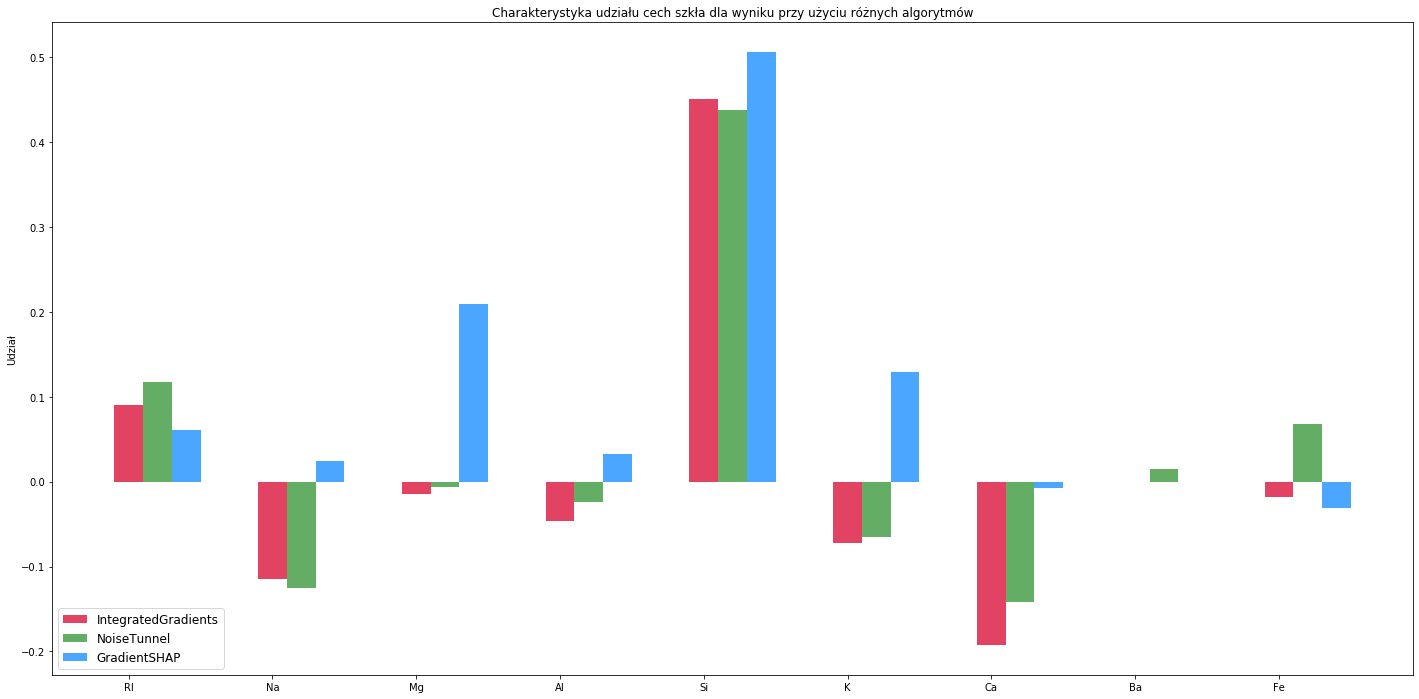

In [11]:
X_train = torch.tensor(train_features).float()
y_train = torch.tensor(train_labels).view(-1, 1).float()

X_test = torch.tensor(test_features).float()
y_test = torch.tensor(test_labels).view(-1, 1).float()

feature_names = ['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe']

ig= IntegratedGradients(net)

attribution =ig.attribute(X_train,target=1)

x_axis_data = np.arange(X_test.shape[1])

ig_attr_test_sum = attribution.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)


nt = NoiseTunnel(ig)
nt_attribution=nt.attribute(X_train, n_steps=100,target=1)

nt_attr_test_sum = nt_attribution.detach().numpy().sum(0)
nt_attr_test_norm_sum = nt_attr_test_sum / np.linalg.norm(nt_attr_test_sum, ord=1)


gs = GradientShap(net)
gs_attribution=gs.attribute(X_train,X_train, target=1)
gs_attr_test_sum = gs_attribution.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

width = 0.2
legends = ['IntegratedGradients', 'NoiseTunnel', 'GradientSHAP']

plp.figure(figsize=(20, 10))

ax = plp.subplot()
ax.set_title('Charakterystyka udziału cech szkła dla wyniku przy użyciu różnych algorytmów')
ax.set_ylabel('Udział')

FONT_SIZE = 16
plp.rc('font', size=FONT_SIZE)            
plp.rc('axes', titlesize=FONT_SIZE)       
plp.rc('axes', labelsize=FONT_SIZE)       
plp.rc('legend', fontsize=FONT_SIZE - 4)  

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#DC143C')
ax.bar(x_axis_data + width, nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#228B22')
ax.bar(x_axis_data + 2 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#1E90FF')

ax.autoscale_view()
plp.tight_layout()

ax.set_xticks(x_axis_data)
ax.set_xticklabels(x_axis_data_labels)

plp.legend(legends, loc=3)
plp.show()

Jak widać różne algorytmy dają różne wyniki dla tych samych cech. Algorytmy IntegratedGradients i NoiseTunnel dają najbardziej zbliżone do siebie wyniki, co wynika z tego, że algorytm NoiseTunnel jest ulepszeniem algorytmu IntegratedGradients przez dodanie do niego szumu gaussowskiego. Różnice pomiędzy dwoma pierwszymi algorytmami a ostatnim mogą wynikać z tego, że GradientShap w czasie kompilowania wybiera losowo punkty na podstawie, których wylicza gradient. Ponadto algorytm ten zakłada, że cechy są od siebie niezależne co może być błędne, bo RI (współczynnik światła) zależy od tego z jakich pierwiastków składa się szkło. Pomimo tego wszystkie algorytmy wskazują marginalny wpływ baru (Ba) na końcowy wynik. Dzięki tej informacji można tą cechę usunąć lub zastąpić cechą, która będzie bardziej istotna.

Poniżej zaprezentuję jeszcze wpływ każdego neuronu na końcowy wynik w ostatniej warstwie sieci neuronowej:

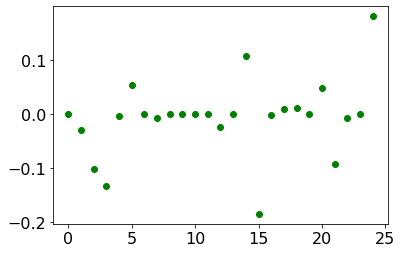

In [13]:
lc = LayerConductance(net, net.linear4)
lc_attr_test = lc.attribute(X_test,target=6, n_steps=100, attribute_to_layer_input=True)


y_axis_lc_attr_test = lc_attr_test[0].mean(0).detach().numpy()
y_axis_lc_attr_test = y_axis_lc_attr_test / np.linalg.norm(y_axis_lc_attr_test, ord=1)


plp.plot(y_axis_lc_attr_test,'go')
plp.show()

Jak widać bardzo duża ilość neuronów osiąga wynik zbliżony do zera co oznacza, że można by zmniejszyć znacząco ilość neuronów przy zachowaniu podobnej skuteczności sieci neuronowej.

## Autorzy
* Jakub Szczudło 
* Mikołaj Żelek 